In [1]:
import numpy as np
#import pandas as pd
#import cvxpy as cvx

import matplotlib.pyplot as plt
import scipy.optimize as scopt
#import seaborn as sns

Методы оптимизации высокого порядка
===================================

Метод Ньютона
-----------------------
Реализуем метод Ньютона:

In [2]:
def Newton(f, grad_f, hess_f, x_0, alpha=1, accuracy=1e-6, max_iter=100):
    iter_count = 0
    
    # Local copy of arg
    x = x_0.copy()
    
    # Saving path to analize
    path = [x]
                     
    while True:
        # Making step
        x = x - alpha * np.linalg.pinv(hess_f(x)) @ grad_f(x)
        
        iter_count += 1
        
        # Saving path
        path.append(x)
        
        # If the required accuracy or max iterations is achieved then stop
        if np.linalg.norm(grad_f(x)) < accuracy or iter_count >= max_iter:
            break
    
    return {"x": x, "iterations": iter_count, "path": path}

Проверим корректность реализации на простой квадратичной функции
$$f(x, y) = x^2 + 2y^2 + xy - 7x - 7y.$$
Нетрудно посчитать, что $(3, 1)$ --- её минимум.

In [3]:
def f(a):
    x = a[0]
    y = a[1]
    return x ** 2 + 2 * y ** 2 + x * y - 7 * x - 7 * y

def grad_f(a):
    x = a[0]
    y = a[1]
    return np.array([2 * x + y - 7, 4 * y + x - 7])

def hess_f(a):
    return np.array([[2, 1], [1, 4]])

res = Newton(f, grad_f, hess_f, [0, 0])
print("Argmin:", res["x"], "\nMin:", f(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [3. 1.] 
Min: -13.999999999999998 
Iterations:  1


Все верно. На квадратичной фукнции, как и ожидалось, метод Ньютона пришел в точку минимума за один шаг.

Рассмотрим теперь функцию Розенброка:
$$rosen(x, y) = (1 - x)^2 + 100(y - x^2)^2.$$
Её многомерное обобщение:
$$rosen(x) = \sum_{i = 1}^{n - 1} \left(\left(1 - x_i^2\right)^2 + 100\left(x_{i + 1} - x_i^2\right)^2 \right).$$
Её глобальный минимум $rosen(x_{min}) = 0$ в точке $x_{min} = (1, \dots, 1)$.

In [4]:
def rosen(x):
    return sum(100.0 * (x[1:] - x[:-1] ** 2)**2 + (1-x[:-1])**2)

def rosen_grad(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

res = Newton(rosen, rosen_grad, rosen_hess, x0)
print("Argmin:", res["x"], "\nMin:", rosen(res["x"]), "\nIterations: ", res["iterations"])

#res = scopt.minimize(rosen, x0, jac=rosen_grad, hess=rosen_hess, method='Newton-CG', tol=1e-6)
#print("Argmin:", res.x, "\nMin:", res.fun, "\nIterations: ", res.nit)

#res = scopt.minimize(rosen, x0, method='Nelder-Mead')
#print("Argmin:", res.x, "\nMin:", res.fun, "\nIterations: ", res.nit)

Argmin: [1.         1.         1.         0.99999999 0.99999999] 
Min: 4.3689477573317777e-17 
Iterations:  19


Сравним метод Ньютона с методами более низкого порядка. Метод первого порядка --- градиентный спуск, нулевого --- метод Нелдера-Мида.

In [61]:
def GradDec(f, grad_f, x_0, alpha=0.01, accuracy=1e-3, max_iter=1000):
    iter_count = 0
    
    # Local copy of arg
    x = x_0.copy()
    
    # Saving path to analize
    path = [x]
                     
    while True:
        # Making step
        x = x - alpha * grad_f(x)
        
        iter_count += 1
        
        # Saving path
        path.append(x)
        
        # If the required accuracy or max iterations is achieved then stop
        if np.linalg.norm(grad_f(x)) < accuracy or iter_count >= max_iter:
            break
    
    return {"x": x, "iterations": iter_count, "path": path}


def NelderMead(func, simplex, alpha=1, beta=0.5, gamma=2, accuracy=0.0001):
    iter_count = 0
    
    # Make a local copy of simplex
    simplex = np.copy(simplex)
    
    # Saving path as mean of simplex
    path = []
    
    n = simplex.shape[1]

    while np.all(np.var(simplex, axis=0) > accuracy):
        path.append(simplex.mean(axis=0))
        iter_count += 1
        
        # Ordering
        func_on_simplex = np.zeros(n + 1)

        for i, x in enumerate(simplex):
            func_on_simplex[i] = func(x)

        index_ordered = np.argsort(func_on_simplex)
        simplex_ordered = simplex[index_ordered]

        # Centroid calculation
        centroid = np.sum(simplex_ordered[:n], axis=0) / n

        # Reflection
        x_r = centroid + alpha * (centroid - simplex_ordered[n])

        if func(x_r) < func(simplex_ordered[0]):
            # Expansion
            x_e = centroid + gamma * (x_r - centroid)
            if func(x_e) < func(x_r):
                simplex[index_ordered[n]] = x_e
            else:
                simplex[index_ordered[n]] = x_r
            continue
        elif func(x_r) < func(simplex_ordered[n - 1]):
            simplex[index_ordered[n]] = x_r
            continue
        else:
            # Contraction
            x_c = centroid + beta * (simplex_ordered[n] - centroid)
            if func(x_c) < func(simplex_ordered[n]):
                simplex[index_ordered[n]] = x_c
            else:
                for i, x_i in enumerate(simplex_ordered[1:]):
                    simplex[i + 1] = simplex_ordered[0] + (x_i - simplex_ordered[0]) / 2
                    
    path.append(simplex.mean(axis=0))
    return {"x": np.mean(simplex, axis=0), "iterations": iter_count, "path": path}

Сравнивать будем на двумерной функции Розенброка, чтобы визуализировать пути методов.

- Newton:
| Argmin: [1. 1.] 
| Min: 1.67632942359465e-30 
| Iterations:  5
- Gradient descent:
| Argmin: [0.95750425 0.91663995] 
| Min: 0.001808931682072844 
| Iterations:  1000
- Nelder-Mead:
| Argmin: [0.99869796 0.99648755] 
| Min: 8.45173821955456e-05 
| Iterations:  36


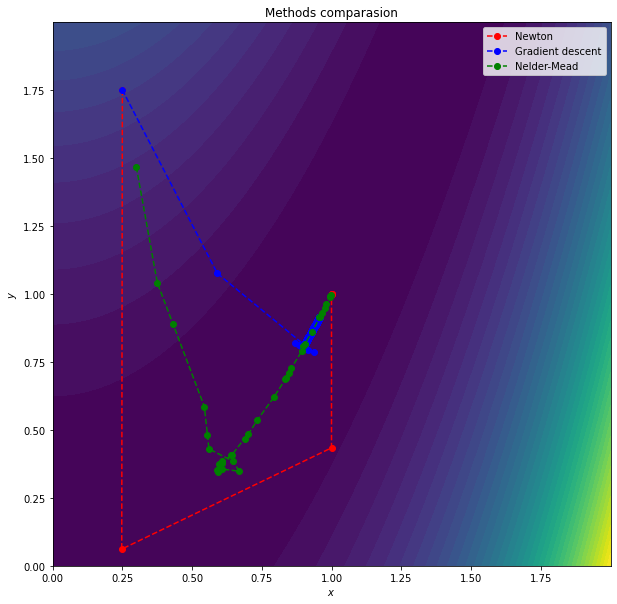

In [80]:
def plot_comparation(X, Y, f, paths_info):
    x, y = np.meshgrid(X, Y)

    plt.figure(figsize=(10, 10))
    plt.contourf(x, y, rosen(np.array([x,y])), levels=50)
    
    for path_info in paths_info:
        path = path_info["path"]
        plt.plot(path[:, 0].squeeze(), path[:, 1].squeeze(), path_info["style"], label=path_info["name"])
    
    plt.title("Methods comparasion")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.legend()


x0 = np.array([0.25, 1.75])

res = Newton(rosen, rosen_grad, rosen_hess, x0)
print("- Newton:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info = [{"path": np.array(res["path"]), "name": "Newton", "style": "ro--"}]

res = GradDec(rosen, rosen_grad, x0, alpha=0.002, accuracy=0.01)
print("- Gradient descent:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info.append({"path": np.array(res["path"]), "name": "Gradient descent", "style": "bo--"})

simplex = [[0.25, 1.75], [0.15, 1.65], [0.5, 1.]]

res = NelderMead(rosen, simplex)
print("- Nelder-Mead:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info.append({"path": np.array(res["path"]), "name": "Nelder-Mead", "style": "go--"})

X = np.arange(0, 2, 0.001)
plot_comparation(X, X, rosen, paths_info)

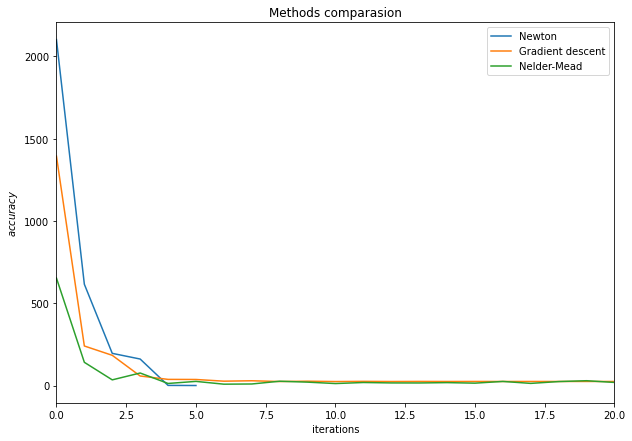

In [81]:
plt.figure(figsize=(10, 7))
for id in range(3):
    plt.plot(np.linalg.norm(rosen_grad(paths_info[id]["path"]), axis=1), label=paths_info[id]["name"])

plt.title("Methods comparasion")
plt.xlabel("iterations")
plt.ylabel("$accuracy$")
plt.xlim(0, 20)
plt.legend()
plt.show()

BFGS
--------
Реализуем метод BFGS:

In [ ]:
def BFGS(f, grad_f, hess_f, x_0, alpha=1, accuracy=1e-6, max_iter=100):
    iter_count = 0
    
    # Local copy of arg
    x = x_0.copy()
    
    # Saving path to analize
    path = [x]
                     
    while True:
        # Making step
        x = x - alpha * np.linalg.pinv(hess_f(x)) @ grad_f(x)
        
        iter_count += 1
        
        # Saving path
        path.append(x)
        
        # If the required accuracy or max iterations is achieved then stop
        if np.linalg.norm(grad_f(x)) < accuracy or iter_count >= max_iter:
            break
    
    return {"x": x, "iterations": iter_count, "path": path}

- Newton:
| Argmin: [1. 1.] 
| Min: 0.0 
| Iterations:  5
Argmin: [0.99997669 0.9999512 ] 
Min: 1.0207375336454984e-09 
Iterations:  48
Argmin: [0.99999928 0.99999855] 
Min: 5.240419093544266e-13 
Iterations:  14


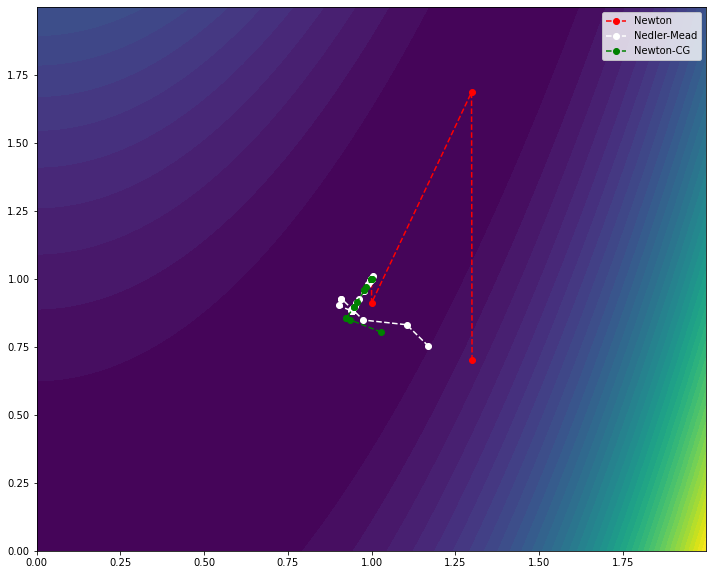

In [7]:

path = []
        
def callback(x):
    global path
    path.append(x)
        
x0 = np.array([1.3, 0.7])
res = Newton(rosen, rosen_grad, rosen_hess, x0)
print("- Newton:\n| Argmin:", res["x"], "\n| Min:", rosen(res["x"]), "\n| Iterations: ", res["iterations"])
paths_info = [{"path": np.array(res["path"]), "name": "Newton", "style": "ro--"}]

res = scopt.minimize(rosen, x0, method='Nelder-Mead', callback=callback)
print("Argmin:", res.x, "\nMin:", res.fun, "\nIterations: ", res.nit)
paths_info.append({"path": np.array(path), "name": "Nedler-Mead", "style": "wo--"})
path = []
res = scopt.minimize(rosen, x0, jac=rosen_grad, hess=rosen_hess, method='Newton-CG', tol=1e-6, callback=callback)
print("Argmin:", res.x, "\nMin:", res.fun, "\nIterations: ", res.nit)
paths_info.append({"path": np.array(path), "name": "Newton-CG", "style": "go--"})

X = np.arange(0, 2, 0.001)
plot_comparation(X, X, rosen, paths_info)

In [8]:
A = np.random.rand(10, 10)

def f(x):
    return x.T @ A @ x

def grad_f(x):
    return (A + A.T) @ x

def hess_f(x):
    return A + A.T

res = Newton(f, grad_f, hess_f, np.ones(10) * 7)
print("Argmin:", res["x"], "\nMin:", f(res["x"]), "\nIterations: ", res["iterations"])

Argmin: [-1.06581410e-14  0.00000000e+00  7.10542736e-14  1.24344979e-14
  2.84217094e-14  3.19744231e-14 -1.42108547e-14 -7.10542736e-15
  3.55271368e-15 -3.55271368e-15] 
Min: 6.049245254290376e-27 
Iterations:  1


In [9]:
def f(x):
    return 8 * x[0]^2 + 5 * x[1]^2 + 4 * x[0] * x[1]

def grad_f(x):
    return np.array([16 * x[0] + 4 * x[1], 10 * x[1] + 4 * x[0]])

def hess_f(x):
    return np.array([[16, 4], [4, 10]])

In [10]:
print(Newton(f, grad_f, hess_f, [10, 10]))

{'x': array([0., 0.]), 'iterations': 1, 'path': [[10, 10], array([0., 0.])]}
